## Import libraries

In [ ]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math

In [ ]:
from resurfemg.config import Config
from resurfemg.tmsisdk_lite import Poly5Reader
import resurfemg.helper_functions as hf

## Reruns should be done from this cell as the start

In [9]:
config = Config()

root_emg_directory = config.get_directory('root_emg_directory')

In [16]:
name_emg = 'C:/Users/judit/OneDrive - UMCG/EMG - asynchronies - analyse/Data devent/Pt_8.Poly5'

In [17]:
data_emg = Poly5Reader(name_emg)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  C:/Users/judit/OneDrive - UMCG/EMG - asynchronies - analyse/Data devent/Pt_8.Poly5
	 Number of samples:  5596912 
	 Number of channels:  18 
	 Sample rate: 500 Hz
Done reading data.


In [18]:
data_samples.shape

(18, 5596912)

In [26]:
dia_f=data_samples[1]

In [27]:
plt.plot(dia_f)

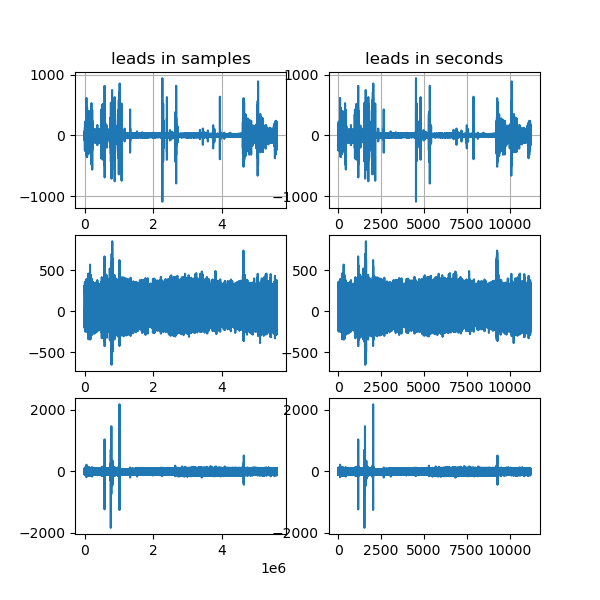

In [28]:
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

In [ ]:
## Notch filter

In [31]:
dia_f_filt=hf.notch_filter(dia_f, 500, 50, 1)

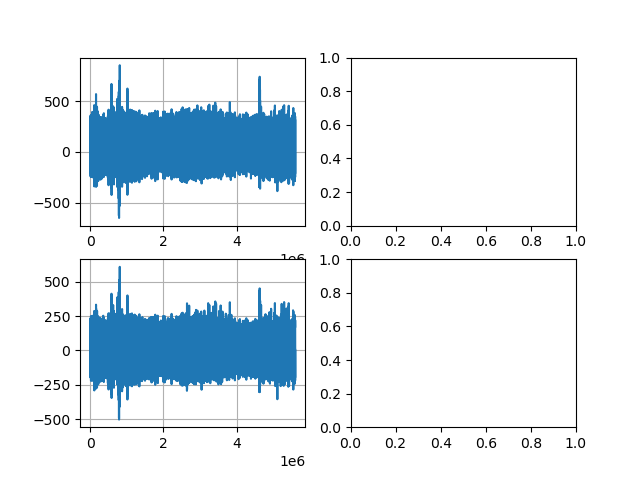

In [42]:
x = dia_f
fig, axis = plt.subplots(nrows = 2, ncols = 2)
axis[0,0].grid(True)
axis[0,0].plot(dia_f)
axis[1,0].plot(dia_f_filt)
axis[1,0].grid(True)

In [ ]:
## Gating

In [ ]:
dia_f_gated=hf.gating(dia_f_filt,)